- 모든 변수 활용
- 로그 변환 -> 표준 정규화(RobustScaler) -> PCA -> 군집화

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rc('font',family = 'NanumBarunGothic')

# **0. 데이터 준비**

- **행정동** 단위까지 구분되어 있는 데이터로 군집화 수행
- 현재 데이터의 경우 상위 10개의 업종이 선택되어 있는 상태

In [3]:
df = pd.read_csv("./datasets/final_행정동.csv",encoding ="euc-kr")
df.head(10)

,행정구,행정동,갈비/삼겹살,닭/오리요리,분식,양식,유흥주점,일식/수산물,제과제빵떡케익,커피점/카페,...,폐업점포영업개월,10대 미만,10대,20 ~ 30대,40 ~ 50대,60대,70대 이상,총인구,역(전체),역(환승역)
0,종로구,청운효자동,4,4,27,34,11,9,12,50,...,62.0,703,1134,3081,4020,1419,1530,11887,0,0
1,종로구,사직동,13,14,51,66,37,41,24,131,...,62.0,532,681,2643,3037,1212,1274,9379,2,0
2,종로구,삼청동,1,0,17,42,10,9,7,95,...,58.0,121,218,646,814,432,428,2659,1,0
3,종로구,부암동,1,3,12,25,6,8,13,54,...,62.0,453,844,2575,3184,1311,1223,9590,0,0
4,종로구,평창동,4,5,17,18,13,10,7,51,...,62.0,1119,1550,4381,5911,2715,2276,17952,0,0
5,종로구,무악동,2,3,5,0,4,1,4,10,...,71.0,594,943,1721,2792,1048,986,8084,0,0
6,종로구,교남동,3,7,9,5,3,5,2,13,...,65.0,788,824,2691,3438,1188,1119,10048,1,0
7,종로구,가회동,2,4,17,34,9,7,7,69,...,62.0,190,308,997,1405,581,605,4086,0,0
8,종로구,"종로1,2,3,4가동",44,39,135,130,141,116,38,308,...,70.0,350,408,2586,2670,1382,1123,8519,4,3
9,종로구,"종로5,6가동",13,15,30,10,55,21,7,54,...,69.0,92,208,2249,1450,778,732,5509,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   행정구             426 non-null    object 
 1   행정동             426 non-null    object 
 2   갈비/삼겹살          426 non-null    int64  
 3   닭/오리요리          426 non-null    int64  
 4   분식              426 non-null    int64  
 5   양식              426 non-null    int64  
 6   유흥주점            426 non-null    int64  
 7   일식/수산물          426 non-null    int64  
 8   제과제빵떡케익         426 non-null    int64  
 9   커피점/카페          426 non-null    int64  
 10  패스트푸드           426 non-null    int64  
 11  한식/백반/한정식       426 non-null    int64  
 12  총생활인구수_평일       426 non-null    float64
 13  10대 미만 생활인구_평일  426 non-null    float64
 14  10대 생활인구_평일     426 non-null    float64
 15  20~30대 생활인구_평일  426 non-null    float64
 16  40~50대 생활인구_평일  426 non-null    float64
 17  60대 생활인구_평일     426 non-null    flo

- 총 48개의 컬럼, 426개의 데이터(행, 행정구 단위)
    - 음식 업종 수(10개) + 변수(38개)
- 결측치는 존재하지 않는다.

# **1. 데이터 선택 & EDA**

In [5]:
### 일식 업종만 선택

df_fish = pd.concat([df.iloc[:,0:2],df.iloc[:,7],df.iloc[:,12:]],axis = 1)
df_fish.head()

,행정구,행정동,일식/수산물,총생활인구수_평일,10대 미만 생활인구_평일,10대 생활인구_평일,20~30대 생활인구_평일,40~50대 생활인구_평일,60대 생활인구_평일,70대 이상 생활인구_평일,...,폐업점포영업개월,10대 미만,10대,20 ~ 30대,40 ~ 50대,60대,70대 이상,총인구,역(전체),역(환승역)
0,종로구,청운효자동,9,442579.2181,36890.666270,59721.67251,118156.80220,136514.38100,41904.34735,49391.34980,...,62.0,703,1134,3081,4020,1419,1530,11887,0,0
1,종로구,사직동,41,661216.6660,20794.603460,30301.91251,248640.53090,253453.84450,57569.56687,50456.20774,...,62.0,532,681,2643,3037,1212,1274,9379,2,0
2,종로구,삼청동,9,136737.9628,4350.119023,11496.49443,46901.51971,46193.60565,14393.21275,13403.01152,...,58.0,121,218,646,814,432,428,2659,1,0
3,종로구,부암동,8,345738.9314,21123.463860,45104.07425,93415.85532,104282.97340,39364.52067,42448.04404,...,62.0,453,844,2575,3184,1311,1223,9590,0,0
4,종로구,평창동,10,426374.0894,26428.814860,45665.26199,92648.95199,138908.72900,60519.32400,62203.00899,...,62.0,1119,1550,4381,5911,2715,2276,17952,0,0


### **1-1. 데이터 세트의 왜곡 정도 낮추기**
- Scipy의 stats 모듈의 **skew()** 함수를 이용해 추출
- 반환 값이 1 이상인 경우 왜곡 정도가 높다고 판단
    - 상황에 따라 편차는 존재함
    - 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 **Box-Cox 변환**을 적용

In [6]:
### 데이터 왜곡 정도 확인
# 왜곡 정도가 1 이상인 컬럼들만 추출

from scipy.stats import skew

features_idx = df_fish.dtypes[df_fish.dtypes != 'object'].index
skew_features = df_fish[features_idx].apply(lambda x:skew(x))
print('전체 왜곡 정도: %f' %skew_features.mean())

skew_features_top = skew_features[skew_features > 1]
print()
print(skew_features_top.sort_values(ascending = False))

전체 왜곡 정도: 1.894037

온라인대학             9.067077
폐업점포영업개월          5.331192
일반대학              4.028578
대학교(전체)           3.734072
일식/수산물            3.668970
20~30대 생활인구_평일    3.371157
20~30대 생활인구_주말    2.721569
역(환승역)            2.641843
40~50대 생활인구_평일    2.564897
10대 미만 생활인구_주말    2.307946
10대 미만 생활인구_평일    2.301757
고등학교              2.177506
총생활인구수_평일         2.143750
10대 생활인구_주말       2.115052
평균소득금액            1.971216
10대 생활인구_평일       1.870536
역(전체)             1.714661
10대               1.674350
10대 미만            1.595705
총생활인구수_주말         1.248200
초중고(전체)           1.209511
60대 생활인구_평일       1.119989
40~50대 생활인구_주말    1.066090
70대 이상 생활인구_평일    1.013370
dtype: float64


In [7]:
### 로그 변환 적용
# 로그 변환 적용 시 최솟값이 0보다 커야함

skewed = list(skew_features_top.index)

for ftr in skewed:
    df_fish[ftr] = np.log1p(df_fish[ftr])

df_fish.head()

,행정구,행정동,일식/수산물,총생활인구수_평일,10대 미만 생활인구_평일,10대 생활인구_평일,20~30대 생활인구_평일,40~50대 생활인구_평일,60대 생활인구_평일,70대 이상 생활인구_평일,...,폐업점포영업개월,10대 미만,10대,20 ~ 30대,40 ~ 50대,60대,70대 이상,총인구,역(전체),역(환승역)
0,종로구,청운효자동,2.302585,13.000377,10.515741,10.997467,11.679776,11.824193,10.643169,10.807551,...,4.143135,6.556778,7.034388,3081,4020,1419,1530,11887,0.000000,0.0
1,종로구,사직동,3.737670,13.401838,9.942497,10.318999,12.423768,12.442941,10.960767,10.828881,...,4.143135,6.278521,6.525030,2643,3037,1212,1274,9379,1.098612,0.0
2,종로구,삼청동,2.302585,11.825829,8.378188,9.349884,10.755827,10.740618,9.574582,9.503309,...,4.077537,4.804021,5.389072,646,814,432,428,2659,0.693147,0.0
3,종로구,부암동,2.197225,12.753442,9.958187,10.716750,11.444827,11.554873,10.580646,10.656060,...,4.143135,6.118097,6.739337,2575,3184,1311,1223,9590,0.000000,0.0
4,종로구,평창동,2.397895,12.963075,10.182248,10.729115,11.436584,11.841580,11.010735,11.038175,...,4.143135,7.021084,7.346655,4381,5911,2715,2276,17952,0.000000,0.0


- 데이터가 제대로 변환되었음을 확인할 수 있다.

In [8]:
### 데이터 왜곡 정도 재확인

features_idx = df_fish.dtypes[df_fish.dtypes != 'object'].index
skew_features = df_fish[features_idx].apply(lambda x:skew(x))
print('전체 왜곡 정도: %f' %skew_features.mean())

전체 왜곡 정도: 0.581749


- 여전히 데이터가 왜곡된 형태임을 확인할 수 있다.

### **1-3. 스케일 조정**
- 데이터의 패턴이 결과에 직접적으로 영향을 미치는 비지도학습의 경우 데이터 스케일링이 선행되는 것이 권장된다.
- 피처 스케일링 방법 중 '표준 정규화' 진행
    - RobustScaler의 경우 이상치(outlier)의 영향을 최소화한 스케일링 기법임
    - RobustScaler로 평균과 표준편차를 재조정

In [9]:
### 데이터 스케일링

from sklearn.preprocessing import RobustScaler

feature_df = df_fish.iloc[:,2:] # feature data
feature_df = feature_df.drop(['상권변화지표'],axis = 1) # 불필요한 컬럼 제거

# 표준 정규화
scaler = RobustScaler()
fish_rbs = pd.DataFrame(scaler.fit_transform(feature_df),columns = feature_df.columns)

# 결과 확인을 위해 행정구,행정동 컬럼 결합
fish_rbs = pd.concat([pd.DataFrame(df_fish[['행정구','행정동']]),fish_rbs],axis = 1)
fish_rbs.head(3) # 표준화된 데이터 확인

,행정구,행정동,일식/수산물,총생활인구수_평일,10대 미만 생활인구_평일,10대 생활인구_평일,20~30대 생활인구_평일,40~50대 생활인구_평일,60대 생활인구_평일,70대 이상 생활인구_평일,...,폐업점포영업개월,10대 미만,10대,20 ~ 30대,40 ~ 50대,60대,70대 이상,총인구,역(전체),역(환승역)
0,종로구,청운효자동,-0.292786,-0.240037,0.140613,0.389700,-0.319431,-0.200439,-0.527156,-0.239310,...,1.098256,-0.609184,-0.388550,-0.867803,-0.749932,-0.982361,-0.616883,-0.920728,-1.000000,0.0
1,종로구,사직동,0.955972,0.405190,-0.575524,-0.459395,0.559238,0.745078,0.023669,-0.201296,...,1.098256,-0.962794,-1.064625,-0.978041,-1.019025,-1.113936,-0.801587,-1.148010,0.584963,0.0
2,종로구,삼청동,-0.292786,-2.127766,-2.529769,-1.672232,-1.410634,-1.856263,-2.380455,-2.563752,...,0.486601,-2.836597,-2.572391,-1.480652,-1.627566,-1.609725,-1.411977,-1.756995,0.000000,0.0


### **1-4. 각 속성 간의 상관도 확인**

c:\users\doroc\appdata\local\programs\python\python37\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\users\doroc\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


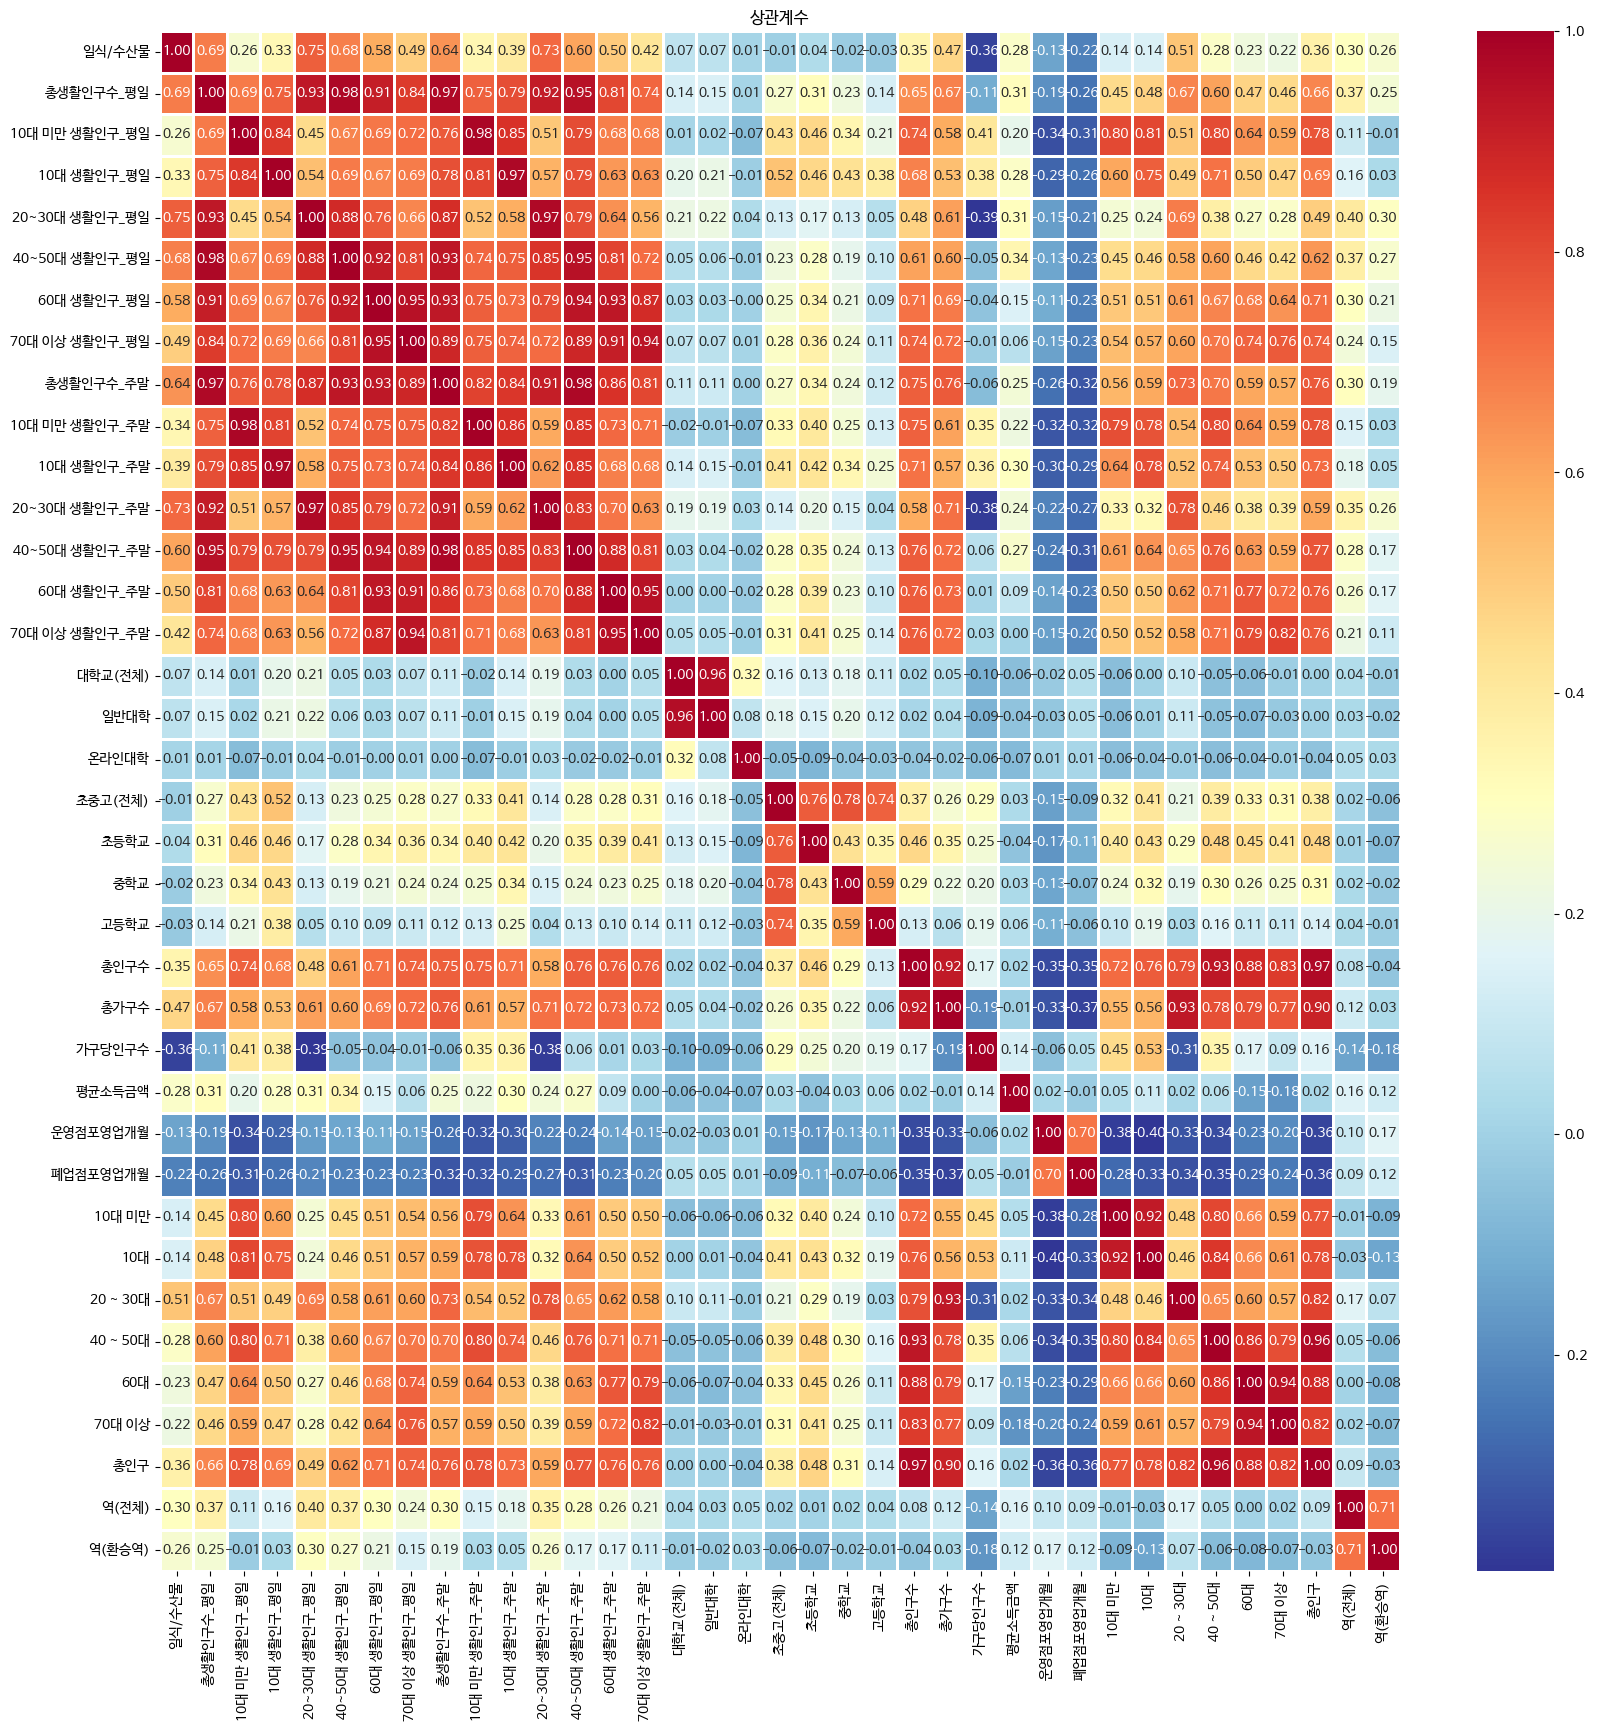

In [10]:
corr = df_fish.corr() # 상관계수

### 히트맵 사이즈 설정
plt.figure(figsize = (20,20))

### 시각화
sns.heatmap(data = corr, # 상관계수 테이블
           annot = True, # 히트맵에 상관계수 값 표시
           fmt = '.2f', # 소수 둘째자리까지 표시
           linewidths = 1., # 경계선
           cmap = 'RdYlBu_r') # colormap 지정
plt.title('상관계수')
plt.show()

- 대부분의 데이터들에서 변수들 간의 상관도가 높은 경향을 보인다.

### **1-5. 변수 선택**
- 모든 변수를 활용하되, PCA를 통해 데이터의 차원을 축소시킨 후 군집화 진행
    - 높은 상관도를 가지는 속성들의 경우 소수의 PCA만으로 각 속성들의 변동성을 모두 설명할 수 있음

In [11]:
### 적절한 주성분 개수 구하기

from sklearn.decomposition import PCA

data = fish_rbs.iloc[:,3:] # 각 데이터 내의 모든 독립변수

pca = PCA(n_components = 36) # 독립변수는 전체 36개
pca_arr = pca.fit_transform(data)
pca_df = pd.DataFrame(pca_arr,index = data.index,
                      columns = [f'pca{num+1}' for num in range(data.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36
0,1.769052,-0.834929,1.313684,1.826664,1.150564,-0.514537,-0.480790,-0.797474,-1.139786,1.282100,...,0.009987,0.038312,-0.026940,-0.002394,-0.054341,-0.012092,-0.041670,0.007373,0.006906,-0.003382
1,2.597421,2.452953,1.092599,1.046172,-0.603962,-0.855466,0.097555,0.755913,-0.289790,0.133024,...,-0.067926,0.035515,-0.000022,0.042015,-0.038524,0.003217,-0.017506,0.001720,-0.002723,0.024867
2,9.143194,-0.737031,-0.909962,1.067440,1.718758,-0.096167,0.239134,-0.726461,1.239239,1.243670,...,-0.057123,-0.073411,-0.014773,0.103294,-0.076483,0.007615,-0.068623,0.003821,0.010180,0.009856
3,3.307531,-0.976638,0.677644,1.238951,1.073823,-0.746903,-0.340713,0.740083,-0.687653,1.522216,...,0.021611,0.003743,-0.057889,-0.000028,-0.038235,0.053447,0.098760,0.006929,0.012932,0.010720
4,1.286197,0.060243,0.971078,0.523100,-1.968257,-0.190823,-1.101871,-0.767785,0.208411,0.754966,...,0.043074,-0.087786,-0.035786,0.027676,0.019280,-0.019012,0.050181,0.003311,-0.018457,0.011201


In [12]:
### 주성분의 설명력과 기여율 구하기

result = pd.DataFrame({'설명 가능한 분산 비율(고윳값)':pca.explained_variance_,
                      '기여율':pca.explained_variance_ratio_},
                     index = np.array([f'pca{num+1}' for num in range(data.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result.loc[(result['설명 가능한 분산 비율(고윳값)'] >= 0.7),:]

,설명 가능한 분산 비율(고윳값),기여율,누적기여율
pca1,11.496356,0.508878,0.508878
pca2,2.544058,0.112611,0.621489
pca3,1.830699,0.081035,0.702524
pca4,1.518437,0.067213,0.769736
pca5,1.321414,0.058491,0.828228


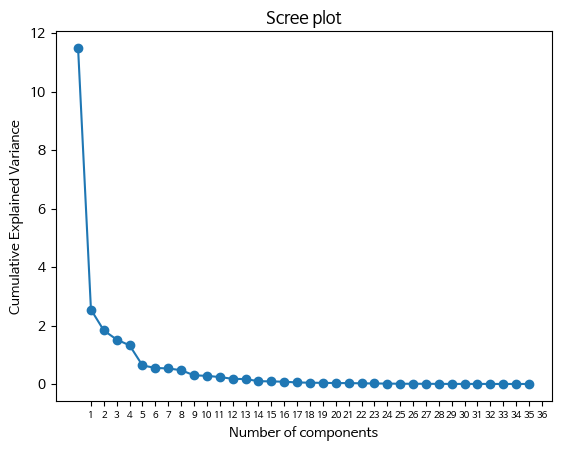

In [13]:
### Scree Plot

plt.title('Scree plot')
plt.xlabel('Number of components')
plt.xticks(range(1,37),fontsize = 7)
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_,'o-')

- 개별 고윳값(주성분마다의 고윳값)이 **0.7 이상**이고 누적 기여율이 **80% 이상**이 넘어가는 지점까지의 주성분들을 기준으로 하여 적절한 주성분 개수를 설정
    - **제 5** 주성분까지 활용

In [14]:
### 차원 축소

from sklearn.decomposition import PCA

pca = PCA(n_components = 5) # pca 객체 생성
pca.fit(fish_rbs.iloc[:,3:]) # pca 학습
# 변환
data_pca = pd.DataFrame(data = pca.transform(fish_rbs.iloc[:,3:]), 
                        columns=['var1', 'var2','var3','var4','var5'])
# 변환된 데이터 저장
fish_trans = pd.concat([pd.DataFrame(df_fish[['행정구','행정동','일식/수산물']]),data_pca], axis = 1)
fish_trans.head(3)

,행정구,행정동,일식/수산물,var1,var2,var3,var4,var5
0,종로구,청운효자동,2.302585,1.769052,-0.834929,1.313684,1.826664,1.150564
1,종로구,사직동,3.737670,2.597421,2.452953,1.092599,1.046172,-0.603962
2,종로구,삼청동,2.302585,9.143194,-0.737031,-0.909962,1.067440,1.718758


# **2. K-Means 군집화**

In [15]:
from sklearn.cluster import KMeans

### **2-1. 군집 개수 정하기**

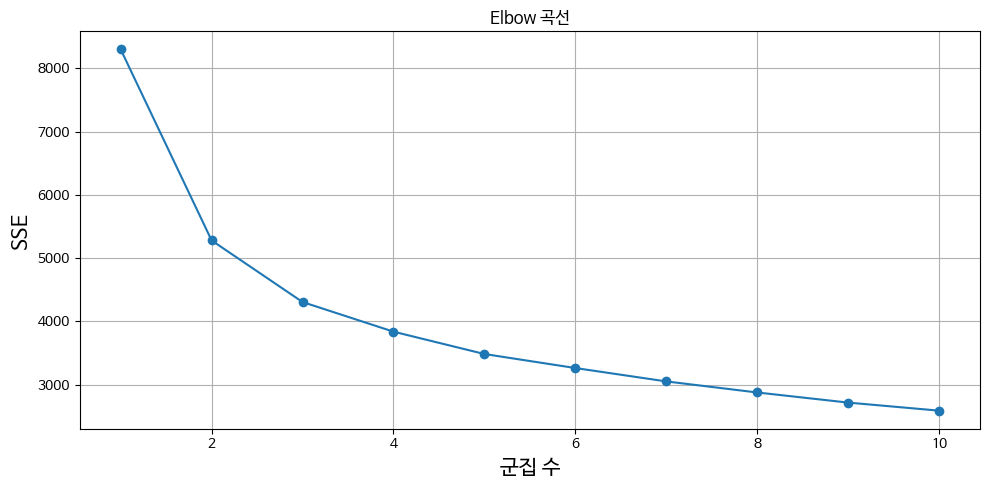

In [16]:
### Inertia, Elbow 구하기

# 중심점 - 데이터 거리를 합산한 inertia(sse)를 빈 array로 생성
sse = []

# 반복문을 실행하며 군집 개수 1~10까지 kmeans를 실행 => sse array에 추가
for i in range(1, 11) :
    km = KMeans(n_clusters = i, # 군집화 할 개수
               init = 'k-means++', # 초기에 군집 중심점의 좌표를 설정할 방식
               n_init = 10,
               max_iter = 300, # 최대 반복 횟수
               random_state = 0)
    km.fit(fish_trans.iloc[:,2:]) # '행정구','행정동' 컬럼 제거
    sse.append(km.inertia_)

# sse array 시각화   
plt.figure(figsize = (10,5))
plt.title('Elbow 곡선')
plt.plot(range(1,11), sse, marker = 'o')
plt.xlabel('군집 수',fontsize = 15)
plt.ylabel('SSE', fontsize = 15)
plt.tight_layout()
plt.grid()
plt.show()

- **k = 3**일 때 급격한 거리의 변화가 일어난 것으로 보아 클러스터 수로 **3개**가 적절해 보인다.

### **2-2. K-Means 군집화 수행**

In [17]:
### 데이터를 3개의 그룹으로 군집화
# 군집화 시 행정구 컬럼은 필요 없으므로 제외

kmeans = KMeans(
    n_clusters = 3, 
    init = 'k-means++', 
    max_iter = 300, 
    random_state = 0)
kmeans.fit(fish_trans.iloc[:,2:])

KMeans(n_clusters=3, random_state=0)

In [18]:
### 각 행정구가 어느 군집화 중심에 속하는지 확인

fish_trans['cluster'] = kmeans.labels_ # 군집화 컬럼 추가
print(kmeans.labels_)
print()
print(len(kmeans.labels_))

[1 2 2 2 1 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 2 2 2 0 1 2 2 2 1 2 2 2 0 1 1 1 1 2 1 1 2 0 1 2 1 1 2 2 0 1 2 1 1 0 2 0 1
 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 2 1 1 1 1 1 2 0 1 1 1 1 1 1 0 1 0 2 0 1 1
 1 1 2 1 1 1 1 1 1 1 0 1 0 1 1 1 2 2 0 1 1 0 0 1 1 2 1 1 1 1 1 0 1 0 2 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1
 1 0 1 1 1 2 0 1 1 0 0 0 1 1 2 1 1 2 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0
 0 1 1 1 0 1 1 2 2 2 2 1 1 1 0 0 1 1 0 1 1 0 0 2 1 1 0 1 0 0 2 2 0 0 0 0 1
 1 0 1 0 0 1 0 2 1 1 0 1 1 1 0 1 1 0 0 1 1 2 0 1 2 1 2 1 0 0 1 0 2 0 1 1 1
 2 2 2 1 1 1 1 1 0 2 0 1 1 1 0 1 0 1 2 2 0 1 1 1 2 1 1 1 0 0 2 1 1 1 2 1 1
 1 2 1 1 1 1 1 1 0 0 0 0 2 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 2 0 1 0 1 1 1 1 2 0 2 1 2 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 2
 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 2 0]

426


In [19]:
### 군집화 결과 확인

df_result = fish_trans.groupby(['cluster'])['행정동'].count()
print(df_result)

cluster
0    121
1    218
2     87
Name: 행정동, dtype: int64


In [20]:
### 시각화
# 평면에 시각화를 위해 추가적인 PCA를 통해 속성을 2개로 차원 축소
# 이후 X좌표, Y좌표로 개별 데이터를 표현

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(fish_trans.iloc[:,2:-1])

fish_trans['pca_x'] = pca_transformed[:,0]
fish_trans['pca_y'] = pca_transformed[:,1]
fish_trans.head(3)

,행정구,행정동,일식/수산물,var1,var2,var3,var4,var5,cluster,pca_x,pca_y
0,종로구,청운효자동,2.302585,1.769052,-0.834929,1.313684,1.826664,1.150564,1,1.805120,-0.772916
1,종로구,사직동,3.737670,2.597421,2.452953,1.092599,1.046172,-0.603962,2,2.395701,2.789051
2,종로구,삼청동,2.302585,9.143194,-0.737031,-0.909962,1.067440,1.718758,2,9.105281,-0.156620


c:\users\doroc\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


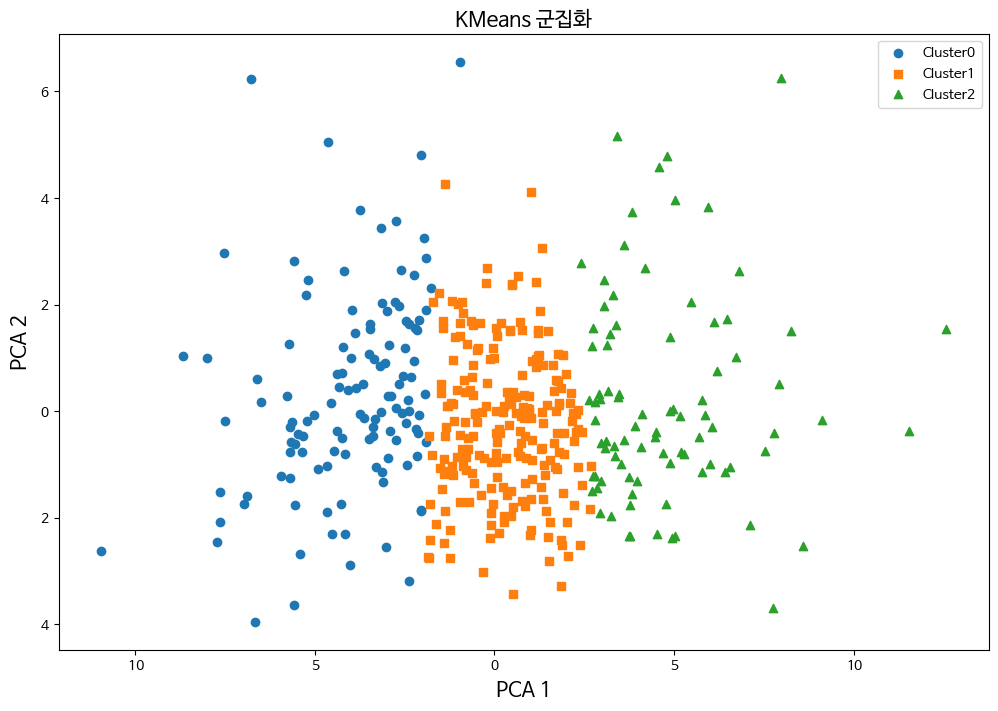

In [21]:
### 군집별 산점도 출력

# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = fish_trans[fish_trans['cluster'] == 0].index
marker1_ind = fish_trans[fish_trans['cluster'] == 1].index
marker2_ind = fish_trans[fish_trans['cluster'] == 2].index

# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. 마커 표시
plt.figure(figsize = (12,8))

plt.scatter(x = fish_trans.loc[marker0_ind,'pca_x'],y = fish_trans.loc[marker0_ind,'pca_y'],marker='o')
plt.scatter(x = fish_trans.loc[marker1_ind,'pca_x'],y = fish_trans.loc[marker1_ind,'pca_y'], marker='s')
plt.scatter(x = fish_trans.loc[marker2_ind,'pca_x'],y = fish_trans.loc[marker2_ind,'pca_y'], marker='^')

plt.legend(['Cluster0','Cluster1','Cluster2'],fontsize = 10)
plt.xlabel('PCA 1',size = 15)
plt.ylabel('PCA 2',size = 15)
plt.title('KMeans 군집화',size = 15)
plt.show()

In [22]:
### 각 군집에 해당하는 행정동 확인하기

group0 = list(fish_trans.loc[fish_trans['cluster'] == 0,'행정동'])
print("군집0: "+ str(group0))
print()

group1 = list(fish_trans.loc[fish_trans['cluster'] == 1,'행정동'])
print("군집1: "+ str(group1))
print()

group2 = list(fish_trans.loc[fish_trans['cluster'] == 2,'행정동'])
print("군집2: "+ str(group2))

군집0: ['종로1,2,3,4가동', '한강로동', '왕십리도선동', '옥수동', '화양동', '중곡4동', '광장동', '구의3동', '용신동', '제기동', '전농1동', '장안1동', '장안2동', '면목본동', '묵1동', '망우본동', '신내1동', '길음1동', '종암동', '석관동', '송중동', '송천동', '인수동', '창2동', '창4동', '월계3동', '공릉1,3동', '공릉2동', '중계2,3동', '상계1동', '상계6,7동', '녹번동', '불광1동', '갈현2동', '구산동', '대조동', '역촌동', '진관동', '충현동', '신촌동', '연희동', '북가좌2동', '공덕동', '서교동', '성산2동', '상암동', '목1동', '목5동', '신정3동', '신정4동', '염창동', '등촌3동', '화곡1동', '화곡본동', '화곡8동', '가양1동', '발산1동', '우장산동', '공항동', '방화1동', '신도림동', '구로2동', '구로3동', '구로5동', '개봉1동', '오류2동', '가산동', '독산1동', '시흥1동', '영등포동', '여의동', '당산2동', '문래동', '노량진1동', '상도1동', '흑석동', '사당2동', '대방동', '청룡동', '은천동', '서초2동', '서초3동', '서초4동', '잠원동', '반포1동', '반포4동', '양재1동', '양재2동', '논현2동', '압구정동', '청담동', '삼성2동', '대치2동', '역삼1동', '역삼2동', '도곡1동', '도곡2동', '개포2동', '세곡동', '풍납2동', '방이2동', '오금동', '석촌동', '삼전동', '가락본동', '가락2동', '문정2동', '장지동', '위례동', '잠실본동', '잠실2동', '잠실3동', '잠실6동', '강일동', '상일1동', '명일1동', '암사1동', '천호1동', '천호2동', '길동', '둔촌2동']

군집1: ['청운효자동', '평창동', '혜화동', '청파동', '원효로1동', '이촌1동', '

In [23]:
### 각 군집에 해당하는 행정구 확인하기

group0 = list(fish_trans.loc[fish_trans['cluster'] == 0,'행정구'].unique())
print("군집0: "+ str(group0))
print()

group1 = list(fish_trans.loc[fish_trans['cluster'] == 1,'행정구'].unique())
print("군집1: "+ str(group1))
print()

group2 = list(fish_trans.loc[fish_trans['cluster'] == 2,'행정구'].unique())
print("군집2: "+ str(group2))

군집0: ['종로구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']

군집1: ['종로구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']

군집2: ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '은평구', '서대문구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']


### **2-3. 군집화 평가**

#### **a) 실루엣 계수**

In [24]:
### 실루엣 분석을 위한 API 추가

from sklearn.metrics import silhouette_samples, silhouette_score

In [25]:
### 모든 개별 데이터에 대해 실루엣 계수 값 구하기

score_samples = silhouette_samples(fish_trans.iloc[:,2:-3],fish_trans['cluster'])
print('silhouette_samples() return 값의 shape', score_samples.shape)

silhouette_samples() return 값의 shape (426,)


In [26]:
### 모든 데이터의 평균 실루엣 계수값 구하기

average_score = silhouette_score(fish_trans.iloc[:,2:-3],fish_trans['cluster'])
print("실루엣 분석 점수: {0:.3f}".format(average_score))

실루엣 분석 점수: 0.240


In [27]:
### 실루엣 계수 컬럼 추가

fish_trans['silhouette_coef'] = score_samples
fish_trans.head(3)

,행정구,행정동,일식/수산물,var1,var2,var3,var4,var5,cluster,pca_x,pca_y,silhouette_coef
0,종로구,청운효자동,2.302585,1.769052,-0.834929,1.313684,1.826664,1.150564,1,1.805120,-0.772916,0.213689
1,종로구,사직동,3.737670,2.597421,2.452953,1.092599,1.046172,-0.603962,2,2.395701,2.789051,-0.041249
2,종로구,삼청동,2.302585,9.143194,-0.737031,-0.909962,1.067440,1.718758,2,9.105281,-0.156620,0.360054


In [28]:
### 군집별로 실루엣 계수의 평균값 구하기

fish_trans.groupby('cluster')['silhouette_coef'].mean()

cluster
0    0.192630
1    0.281414
2    0.203776
Name: silhouette_coef, dtype: float64

- 군집0이 다른 군집들에 비해 평균값이 조금 높은 편이다.
- 전체적으로 실루엣 계수의 평균값이 낮은 편이다.

#### **b) Davies Bouldin Index**

In [29]:
### Davies Bouldin Index 계산을 위한 API 추가

from sklearn.metrics import davies_bouldin_score

In [30]:
### Davies Bouldin Index 값 구하기

dbi = davies_bouldin_score(fish_trans.iloc[:,2:-3],fish_trans['cluster'])
print("Davies Bouldin Index: {0:.3f}".format(dbi))

Davies Bouldin Index: 1.297


- 값이 1 이상으로 조금 높은 편이다.